In [5]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
tqdm.pandas()
import random
from itertools import islice
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## Final Project ML Course  Start Experiment with Full data

In [2]:
# Loading the CSV file to inspect its contents
file_path = '/lustre/acslab/users/3281/semmeddb_r42.csv'
df = pd.read_csv(file_path)

# Displaying the first few rows of the dataframe to understand its structure
df.head()

,date,pmid,sent_idx,ti_or_ab,pred_type,subj_ids,subj_names,subj_text,subj_type,obj_ids,obj_names,obj_text,obj_type
0,2020-05-26,32455440,3,ab,PROCESS_OF,C0005779,Blood Coagulation Disorders,Coagulopathy,dsyn,C0870668,hospitalized patients,Hospitalized Patients,humn
1,2020-05-19,32455215,11,ab,compared_with,C0063083,Hydrogel,hydrogel,orch,C0063083,Hydrogel,hydrogel,orch
2,2020-05-19,32455215,12,ab,INTERACTS_WITH,C0071703,polyvinyl alcohol hydrogel,PVA/BCP hydrogel,orch,C0162969,chitosan,CS,orch
3,2020-01-01,32455170,8,ab,PROCESS_OF,C5203670,COVID-19,COVID-19,dsyn,C0008059,Child,children,humn
4,2020-05-01,32455147,9,ab,PROCESS_OF,C5203670,COVID-19,coronavirus disease 2019,dsyn,C0030705,Patients,patients,humn


In [3]:
# dataframe.size
size = df.size
print("Size = {}".format(size))
count_row = df.shape[0]  # Gives number of rows
count_col = df.shape[1]  # Gives number of columns
print(count_col)
print(count_row)

Size = 1344486819
13
103422063


### Data PreProcessing to Drop Duplicate 
## Step 1: select only two column from .csv file into data frame (103M)

In [4]:
# Selecting only the 'subj_ids' and 'obj_ids' columns
edge_list = df[['subj_ids', 'obj_ids']]

# Checking the first few rows of the edge list
edge_list

,subj_ids,obj_ids
0,C0005779,C0870668
1,C0063083,C0063083
2,C0071703,C0162969
3,C5203670,C0008059
4,C5203670,C0030705
...,...,...
103422058,C0010674,C0027361
103422059,C5203670,C0027361
103422060,C0006826,C0030705
103422061,C0032105,C1999216


### 1.1 save .pkl file for edge_list with 2 column(103M) drop dupplicate
NOTE: the number of rows has reduced from 103M into 16M into 14M.

In [3]:
# pd.to_pickle(edge_list, "/lustre/acslab/users/3281/fullsemmeddb_matrix.pkl")
edge_list= pd.read_pickle("fullsemmeddb_matrix.pkl")
edge_list_reduced = edge_list.drop_duplicates()
edge_list_reduced

,subj_ids,obj_ids
0,C0005779,C0870668
1,C0063083,C0063083
2,C0071703,C0162969
3,C5203670,C0008059
4,C5203670,C0030705
...,...,...
103422025,C0537969,C0057445
103422027,C1412056|17,G0000145
103422029,C1412056|17,C0057445
103422030,C1148523,C0038952


In [2]:
# pd.to_pickle(edge_list_reduced,"fullsemmeddb_matrix_reduced_dropped.pkl")
edge_list_reduced_dropped= pd.read_pickle("fullsemmeddb_matrix_reduced_dropped.pkl")
edge_list_reduced_dropped

,subj_ids,obj_ids
0,C0005779,C0870668
1,C0063083,C0063083
2,C0071703,C0162969
3,C5203670,C0008059
4,C5203670,C0030705
...,...,...
103422025,C0537969,C0057445
103422027,C1412056|17,G0000145
103422029,C1412056|17,C0057445
103422030,C1148523,C0038952


### 1.3 drop duplicate and convert EdgeList into set (14M)

In [3]:
reduced_dropped_edge_set = set([tuple(sorted(x)) for x in tqdm(edge_list_reduced_dropped.to_numpy())])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 16322866/16322866 [00:21<00:00, 759225.19it/s]


In [4]:
len(reduced_dropped_edge_set)

14661211

In [5]:
reduced_dropped_edge_set_list = list(reduced_dropped_edge_set)
print(reduced_dropped_edge_set_list[:5])

[('C0206131', 'C0324266'), ('C0028908', 'C0030842'), ('C0034493', 'C0051348'), ('C0002844', 'C1518304'), ('C0057933', 'C0085109')]


## step 2: Generate Node_list out of Edge_list:

In [6]:
nodes = set()

# Iterate through each edge and add the nodes to the set
for edge in reduced_dropped_edge_set_list:
    nodes.update(edge)

# Convert the set of unique nodes to a list
node_list = list(nodes)

In [7]:
def generate_node_list(edge_list):
    # Using a set for efficiency as it will automatically handle duplicates
    node_set = set()
    for subj_id, obj_id in edge_list:
        node_set.add(subj_id)
        node_set.add(obj_id)
    return list(node_set)

In [8]:
node_list = generate_node_list(reduced_dropped_edge_set_list)

In [9]:
node_list_list=list(node_list)

In [10]:
len(node_list_list)

304525

In [13]:
node_list_list[:10]

['C0967207',
 'C1011542',
 'C1333918',
 'C0142972',
 'C1082169',
 'C0006558|3416',
 'C0302928',
 'C1005648',
 'C1154187',
 'C0065564']

## Step 3: Negative Sampling (My own Impl)
Note: Number of Nodes: 304K

In [11]:
def negative_sampling(node_list, edge_set, num_samples):
    negative_samples = set()
    pbar = tqdm(total=num_samples)

    while len(negative_samples) < num_samples:
        # Randomly select two nodes
        node1, node2 = random.sample(node_list, 2)

        # Form a tuple (considering undirected graph, sort the tuple)
        edge = tuple(sorted((node1, node2)))

        # Check if this edge is not in the graph
        if (edge not in edge_set) and (edge not in negative_samples):
            negative_samples.add(edge)
            pbar.update(1)

    pbar.close() 
    return negative_samples

In [12]:
tqdm._instances.clear() # reset library itself

In [13]:
# Number of positive samples (existing edges)
num_samples = 14661211

# Generating negative samples
negative_samples = negative_sampling(node_list_list ,reduced_dropped_edge_set, num_samples)

# Checking the first few negative samples
negative_samples_list = list(negative_samples)
print(negative_samples_list[:5])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 14661211/14661211 [00:46<00:00, 314839.80it/s]


[('C0913615', 'C1461430'), ('C0042089|7390', 'C1436881'), ('C0376534', 'C0678910'), ('C0288784', 'C0630238'), ('C0026608', 'C1427841|91522')]


## Step4: Convert data frame to suitable data format for PyTorch Geometric
 4.1. Process data: Usually it is a list of edge tuples or an edge index tensor. 

 4.2. Create a Graph: In order to transform your tabular data into a format that PyTorch Geometric can work with.

In [14]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected

def convert_to_pyg_format(node_list, edge_list):
    # Mapping from node IDs to consecutive integers
    node_id_to_index = {node_id: i for i, node_id in enumerate(node_list)}

    # Convert edge list to edge_index format
    edge_index = [[node_id_to_index[edge[0]], node_id_to_index[edge[1]]] for edge in edge_list]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create PyTorch Geometric Data object
    undirected_edge_index = to_undirected(edge_index)
    data = Data(edge_index=undirected_edge_index)

    return data

# Convert your edge list to PyTorch Geometric format
pyg_data = convert_to_pyg_format(node_list_list, reduced_dropped_edge_set_list)  # Replace 'node_list' and 'edge_list' with your actual data
print(pyg_data.edge_index)
print(pyg_data.edge_index.shape)

tensor([[     0,      1,      1,  ..., 304522, 304523, 304524],
        [291491,      1,   4451,  ..., 297434,  70770,  22493]])
torch.Size([2, 29304764])


In [52]:
# import GPUtil
# import pandas as pd
# import torch
# from torch_geometric.data import Data
# from torch_geometric.utils import to_undirected

# # node_list_list= 304525
# # reduced_dropped_edge_set = 14661211
# # PYG -> edge_index[2,14661211]
# # Create a mapping from node identifiers to indices based on the node list
# node_to_idx = {node: idx for idx, node in enumerate(node_list_list)}

# # Create edge index array
# source_nodes = []
# target_nodes = []
# for source, target in reduced_dropped_edge_set:
#     source_idx = node_to_idx.get(source)
#     target_idx = node_to_idx.get(target)
#     if source_idx is not None and target_idx is not None:
#         source_nodes.append(source_idx)
#         target_nodes.append(target_idx)

# edge_index = [source_nodes, target_nodes]

# # edge_index is a list of lists to a tensor
# edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
# print(edge_index_tensor.shape)
# undirected_edge_index = to_undirected(edge_index_tensor)

# # Creating the graph data object
# graph_data = Data(edge_index=undirected_edge_index)

# print(graph_data.edge_index)
# print(graph_data.edge_index.shape)

torch.Size([2, 14661211])
tensor([[     0,      0,      0,  ..., 304524, 304524, 304524],
        [  1700,   3935,   4440,  ..., 264752, 271693, 289986]])
torch.Size([2, 29304764])


In [16]:
pyg_data

Data(edge_index=[2, 29304764])

## Step5. Train Node2vec Model via Pytorch_geometric

In [17]:
from torch_geometric.nn import Node2Vec
import sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example initialization of Node2Vec
model = Node2Vec(
    pyg_data.edge_index, 
    embedding_dim=2, 
    walk_length=20, 
    context_size=10, 
    walks_per_node=10
).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [18]:
model

Node2Vec(304525, 2)

In [19]:
device

device(type='cuda')

In [20]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, 10):
    loss = train()
    # print(f"VRAM Usage: {GPUtil.getGPUs()[0].memoryUsed / 1024} GB")
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.0260
Epoch: 002, Loss: 0.9215
Epoch: 003, Loss: 0.9188
Epoch: 004, Loss: 0.9176
Epoch: 005, Loss: 0.9161
Epoch: 006, Loss: 0.9137
Epoch: 007, Loss: 0.9116
Epoch: 008, Loss: 0.9111
Epoch: 009, Loss: 0.9109


In [21]:
node2vec_matrix = model().detach().cpu().numpy()

In [22]:
node2vec_matrix.shape

(304525, 2)

In [23]:
pd.to_pickle(node2vec_matrix, "/lustre/acslab/users/3281/finalOutputNode2vec2dim.pkl")

In [17]:
last_df= pd.read_pickle("finalOutputNode2vec2dim.pkl")
last_df

array([[ 0.3456785 ,  0.09172283],
       [-0.01644988,  0.19746818],
       [ 0.56494546,  0.05133802],
       ...,
       [ 0.21722727, -0.267029  ],
       [-0.13212052, -0.00817482],
       [-0.1384197 ,  0.05547517]], dtype=float32)

In [25]:
rows = last_df.shape[0]  
cols = last_df.shape[1]
print(rows)
print(cols)

304525
2


### 5.1 Construct a dict:
1. Construct a dict to make sure each node in the Node2vec matrix has a key as node id and a value as Embedding numeric value to it.

In [18]:
# Create a dictionary of node embeddings
node_embeddings = {node_id: last_df[idx] for idx, node_id in enumerate(node_list_list)}

In [19]:
n = 5  # Number of rows you want to print
for node, embedding in islice(node_embeddings.items(), n):
    print(node, embedding)

C1207207 [0.3456785  0.09172283]
C0180921 [-0.01644988  0.19746818]
6271 [0.56494546 0.05133802]
C0769480 [0.10426185 0.36711827]
C0214617 [ 0.07756905 -0.73447067]


In [20]:
print("First few positive samples:", list(reduced_dropped_edge_set)[:5])
print("First few negative samples:", list(negative_samples)[:5])

First few positive samples: [('C0206131', 'C0324266'), ('C0028908', 'C0030842'), ('C0034493', 'C0051348'), ('C0002844', 'C1518304'), ('C0057933', 'C0085109')]
First few negative samples: [('C0913615', 'C1461430'), ('C0042089|7390', 'C1436881'), ('C0376534', 'C0678910'), ('C0288784', 'C0630238'), ('C0026608', 'C1427841|91522')]


## Step6: run Hadamard fuction (element wise multiplication) to generate edge feature. 

In [21]:
# Function to calculate Hadamard product
def hadamard(v1, v2):
    return np.multiply(v1, v2)

# Function to generate edge features
def generate_edge_features(samples, node_embeddings):
    edge_features = []
    for node1, node2 in tqdm(samples):
        vector1 = node_embeddings.get(node1)
        vector2 = node_embeddings.get(node2)
        
        
        if vector1 is not None and vector2 is not None:
            edge_feature = hadamard(vector1, vector2)
            edge_features.append(edge_feature)
        else:
            # Handle missing vectors if necessary
            pass
    return edge_features

# Assuming you have lists of positive and negative edge samples

positive_edge_features = generate_edge_features(
    list(reduced_dropped_edge_set), node_embeddings
)
negative_edge_features = generate_edge_features(negative_samples, node_embeddings)
print("Length positive samples:", len(positive_edge_features))
print("Length negative samples:", len(negative_samples))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 14661211/14661211 [00:35<00:00, 411115.94it/s]

Length positive samples: 14661211
Length negative samples: 14661211


### 6.1 Assign Label into your samples: 1 for positive samples and 0 for negative samples.
And combine the both negative and positive samples. 

In [22]:
# Assuming positive_edge_features and negative_edge_features are your feature lists

# Assign label 1 to positive samples
labeled_positive_samples = [(feature, 1) for feature in positive_edge_features]

# Assign label 0 to negative samples
labeled_negative_samples = [(feature, 0) for feature in negative_edge_features]

# Combine labeled samples into one dataset
labeled_samples = labeled_positive_samples + labeled_negative_samples

### 6.2 Convert labeled samples to a DataFrame

In [23]:
# Convert the labeled samples to a DataFrame
last_supper_df = pd.DataFrame(labeled_samples, columns=['Edge_Features', 'Label'])
last_supper_df

,Edge_Features,Label
0,"[-0.58807606, -0.13673693]",1
1,"[0.15909651, 0.06349003]",1
2,"[0.36873746, -0.114275075]",1
3,"[0.05965284, 0.320118]",1
4,"[0.40842217, -0.11188945]",1
...,...,...
29322417,"[0.028138552, -0.1270811]",0
29322418,"[0.09818772, -0.0032989958]",0
29322419,"[-0.2065312, 0.07854051]",0
29322420,"[0.09175654, -0.015906949]",0


### 6.3. Save tabular data as a .pkl file

In [32]:
last_supper_df['Edge_Features']

0                 [3.354425, 0.055355825]
1              [3.3581414, -0.0042564482]
2                 [3.8260665, 0.88930106]
3                 [7.7666903, 0.17341365]
4                [7.5005474, 0.012701208]
                        ...              
29322417        [-0.16730517, 0.14943121]
29322418     [-0.106163666, -0.027285438]
29322419    [-0.0040614405, 0.0062651294]
29322420       [-0.15582895, 0.006437663]
29322421     [-0.062082674, -0.013441527]
Name: Edge_Features, Length: 29322422, dtype: object

In [24]:
matrix = np.array(last_supper_df['Edge_Features'].tolist())

In [6]:
# pd.to_pickle(matrix, "/lustre/acslab/users/3281/tabulardata_X2dim.pkl")
matrix= pd.read_pickle("/lustre/acslab/users/3281/tabulardata_X2dim.pkl")

In [7]:
matrix.shape

(29322422, 2)

In [42]:
last_supper_df['Label']

0           1
1           1
2           1
3           1
4           1
           ..
29322417    0
29322418    0
29322419    0
29322420    0
29322421    0
Name: Label, Length: 29322422, dtype: int64

In [43]:
matrix_y = np.array(last_supper_df['Label'].tolist())

In [44]:
matrix_y.shape

(29322422,)

In [8]:
# pd.to_pickle(matrix_y, "/lustre/acslab/users/3281/tabulardata_Y2dim.pkl")
matrix_y = pd.read_pickle("/lustre/acslab/users/3281/tabulardata_Y2dim.pkl")

## Step7. SkLearn Logestic Regression

In [9]:
from sklearn.utils import resample

In [34]:
x_resampled_data, y_resampled_data = resample(matrix, matrix_y, replace=False, n_samples=100)

In [30]:
# len(x_resampled_data)
# len(y_resampled_data)
# y_resampled_data
# sum(y_resampled_data)
y_resampled_data.nonzero()
# df = pd.DataFrame(y_resampled_data)
# df.value_counts()

(array([   1,    4,    5, ..., 9997, 9998, 9999]),)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
     matrix, matrix_y, test_size=0.30, random_state=42)

In [54]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [55]:
clf.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [56]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.9727139912084785

In [35]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

logisticRegr = LogisticRegression(C=1.0)
clf = logisticRegr.fit(x_resampled_data, y_resampled_data)
#model = SVC(kernel='linear')
#clf = model.fit(x_data, y_data)

In [12]:
import matplotlib.pyplot as plt

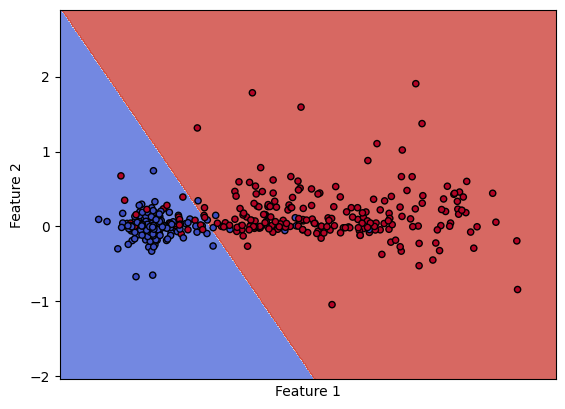

In [37]:
fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = x_resampled_data[:, 0], x_resampled_data[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_resampled_data, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('Feature 2')
ax.set_xlabel('Feature 1')
#ax.set_label(['a', 'b'])
ax.set_xticks(())

# Save it in a pdf file, It won't break when we locate it in 
fig.savefig("plotsamplingP&N.pdf", format='pdf')